# Data preprocess

In [1]:
import numpy as np
import re
import pandas as pd
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
files = open("./data/par_corp.csv", encoding='UTF-8')

re_lines = []
for line in files:
    if line[0] == '[':
        continue
    re_line = re.sub('[#".?!\n]', '', line)
    re_lines.append(re_line)

kor = []
eng = []
count = 0
for line in re_lines:
    count = count + 1
    if count % 2 == 0:
        kor.append(line)
    else:
        eng.append(line)

d = {'kor':kor, 'eng':eng}
par_corp = pd.DataFrame(d)

print(par_corp)

kor                                        eng
0            명령은 아래와 같이 반포되었다                  The order went forth that
1         명령은 반드시 엄격히 준수해야 한다         The orders must be strictly obeyed
2       운명의 여신은 용사를 특별히 애호하신다                  fortune favors the brave 
3         운명에 그가 죽을 것이라고 정해졌다            Fate destined that he shall die
4      운명에 그는 목사가 될 것이라고 정해졌다         Fate had ordained him to die young
...                       ...                                        ...
47662              사자는 야생동물이다                  The lion is a wild animal
47663            사자는 황야로 도망갔다  The lion escaped and returned to the wild
47664   사자는 우리 안에서 천천히 왔다갔다한다       The lion paced the floor of its cage
47665   젖은 셔츠가 그의 몸에 착 달라붙어있다            The wet shirt clung to his body
47666      젖은 성냥은 그어도 켜지지 않는다                  Damp matches won't strike

[47667 rows x 2 columns]


In [6]:
encoder_input, decoder_input, decoder_output = [], [], []

# '나는 개와 산책을 하고 있다'
# ######## 위 문장의 셀 상태랑 은닉 상태 + <start> 가 인풋으로 들어가면
# '<start> i am taking a walk with my dog' -> 각 시점마다 이 문장의 일부분을 decoder_output을 추측하는데 사용하고 있음
# 'i am taking a walk with my dog <end>'

for stc in par_corp['kor']:
    encoder_input.append(stc.split())

# 스타트 뒤에 띄어쓰기 있습니다
for stc in par_corp['eng']:
    decoder_input.append(("<start> "+stc).split())

# 엔드 앞에 띄어쓰기 있습니다
for stc in par_corp['eng']:
    decoder_output.append((stc+" <end>").split())

In [7]:
tokenizer_ko = Tokenizer()
tokenizer_ko.fit_on_texts(encoder_input)
encoder_input = tokenizer_ko.texts_to_sequences(encoder_input)

# 만약에 5000이면, 1~4999(패딩하기 전) -> 0~4999(패딩하고 난 뒤)
tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(decoder_input)
tokenizer_en.fit_on_texts(decoder_output)
decoder_input = tokenizer_en.texts_to_sequences(decoder_input)
decoder_output = tokenizer_en.texts_to_sequences(decoder_output)

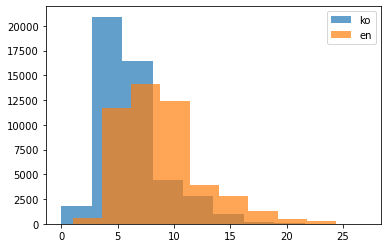

In [8]:
# 문장 길이 체크
import matplotlib.pyplot as plt

len_ko = []
for data in encoder_input:
    len_ko.append(len(data))

len_en = []
for data in decoder_input:
    len_en.append(len(data))

plt.hist(len_ko, label='ko', alpha=0.7)
plt.hist(len_en, label='en', alpha=0.7)
plt.legend()
plt.show()

In [9]:
# maxlen 없어도 알아서 잘 패딩합니다
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_output = pad_sequences(decoder_output, padding="post")

In [10]:
print(encoder_input.shape)
print(decoder_input.shape)

(47667, 27)
(47667, 27)


In [11]:
# 나중에 prediction 할때 사용하기 위함 (인덱스로 단어 찾기)
en_to_index = tokenizer_en.word_index
index_to_en = tokenizer_en.index_word

In [12]:
test_size = 12000
encoder_input_train = encoder_input[:-test_size]
decoder_input_train = decoder_input[:-test_size]
decoder_output_train = decoder_output[:-test_size]

encoder_input_test = encoder_input[-test_size:]
decoder_input_test = decoder_input[-test_size:]
decoder_output_test = decoder_output[-test_size:]

# Training

In [13]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [14]:
# 인코더 - 한글 문장 받아서 LSTM 마지막 시점의 은닉상태/셀상태 리턴하도록
# 원래는 데이터 갯수랑 문장 길이 같이 들어가야함
# 왜 데이터 갯수는 명시하지 않을까요?
# fit 할때 validation data -> test set -> 데이터 갯수 다르기 때문에
encoder_inputs = Input(shape=(27,)) #27은 문장의 길이
# +1을 해서 패딩까지 고려
encoder_embed = Embedding(len(tokenizer_ko.word_index)+1, 50)(encoder_inputs)
# 패딩 값은 필요없는데... (0에 해당하는 임베딩 벡터 제외)
encoder_mask = Masking(mask_value=0)(encoder_embed)
# return state를 쓰면 마지막 은닉 상태, 마지막 은닉 상태, 마지막 셀 상태 값을 리턴
encoder_outputs, h_state, c_state = LSTM(50, return_state=True)(encoder_mask)

In [15]:
# 디코더 - 위에서 리턴한 상태값이랑, 영어 문장 입력받아서 LSTM의 출력값 리턴하도록
decoder_inputs = Input(shape=(27,))
decoder_embed = Embedding(len(tokenizer_en.word_index)+1, 50)(decoder_inputs)
decoder_mask = Masking(mask_value=0)(decoder_embed)
# return sequences를 쓰면 전체 시점의 은닉 상태 값을 리턴
# 둘 다 쓰면 전체 시점의 은닉 상태(단어갯수만큼)/마지막 은닉 상태/마지막 셀 상태 값을 리턴
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=[h_state, c_state])
decoder_dense = Dense(len(tokenizer_en.word_index)+1, activation='softmax')
decoder_softmax_outputs = decoder_dense(decoder_outputs)

In [16]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
# sparse는 라벨이 정수 형태로 제공될 때 사용되는 함수 (그냥 categorical은 원핫 벡터로 라벨이 제공될 때)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
# 레이어 별로 가중치가 학습되는 것임
model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_output_train, validation_data = ([encoder_input_test, decoder_input_test], decoder_output_test), batch_size = 128, epochs = 50)

Train on 35667 samples, validate on 12000 samples
Epoch 1/50
26496/35667 [=====================>........] - ETA: 4:45 - loss: 3.9013 - acc: 0.6779

KeyboardInterrupt: 